## Resnet50v2 with the RGB channels only, scaled down to 60 x 60 pixels, and with 2 epochs

The notebook contains a custom setup of the Resnet50v2 model, which allows for users to configure the input such that (i) the list of remote sensing channels can be flexible and (ii) the dimension of image patches can be uniformaly adjusted (e.g., 20x20, 60x60, and 120x120). Each remote sensing channel input is stacked up and fed into the model all at once.

### Environment and library settings

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
from pathlib import Path
from PIL import Image, ImageShow
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2
from skimage.transform import resize
from tifffile import imread
import time

In [6]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [7]:
!pwd

/home/jupyter


In [8]:
import os
os.listdir('/home/jupyter')

['.config',
 '.nv',
 '.ipython',
 'bigearthnet_model_Resnet50v2-RGB60_epochs2.ipynb',
 '.cache',
 '.jupyter',
 'bigearthnet_model_Resnet50v2.ipynb',
 'data',
 'tutorials',
 '.ipynb_checkpoints',
 '.local',
 '.keras',
 'exploration.ipynb',
 'bigearthnet_model.ipynb',
 'check_gpu.ipynb',
 '.docker']

In [9]:
next(os.walk('/home/jupyter/data/BigEarthNet-v1.0'))[1][0]

'S2A_MSIL2A_20170617T113321_26_63'

In [10]:
os.listdir('/home/jupyter/data/BigEarthNet-v1.0/S2A_MSIL2A_20170613T101032_77_22/')

['S2A_MSIL2A_20170613T101032_77_22_B03.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B04.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B09.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B8A.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B06.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B05.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B12.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B08.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B01.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B11.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B02.tif',
 'S2A_MSIL2A_20170613T101032_77_22_B07.tif',
 'S2A_MSIL2A_20170613T101032_77_22_labels_metadata.json']

In [11]:
data_dir = "/home/jupyter/data/BigEarthNet-v1.0"

In [12]:
img_list = os.listdir(data_dir)
img_list[0:10]

['S2A_MSIL2A_20170617T113321_26_63',
 'S2B_MSIL2A_20170930T095019_61_18',
 'S2B_MSIL2A_20180421T100030_47_74',
 'S2A_MSIL2A_20171002T094031_82_49',
 'S2B_MSIL2A_20180511T100029_37_18',
 'S2A_MSIL2A_20171002T112111_36_14',
 'S2B_MSIL2A_20180525T94030_55_37',
 'S2A_MSIL2A_20180225T114351_15_84',
 'S2A_MSIL2A_20180506T100031_85_20',
 'S2A_MSIL2A_20171101T094131_25_54']

### Configuring the model parameters and constant variables

In [13]:
PIXEL = 60
BATCH_SIZE = 32
BATCH_COUNT = len(img_list)//BATCH_SIZE
CHANNELS = ["B04","B03","B02"]

# B01: Coastal aerosol; 60m
# B02: Blue; 10m
# B03: Green; 10m
# B04: Red; 10m
# B05: Vegetation red edge; 20m
# B06: Vegetation red edge; 20m
# B07: Vegetation red edge; 20m
# B08: NIR; 10m
# B09: Water vapor; 60m
# B11: SWIR; 20m
# B12: SWIR; 20m
# B8A: Narrow NIR; 20m

LABEL_MAP = {'Agro-forestry areas':1,
           'Airports':0,
           'Annual crops associated with permanent crops':1,
           'Bare rock':0,
           'Beaches, dunes, sands':0,
           'Broad-leaved forest':0,
           'Burnt areas':0,
           'Coastal lagoons':0,
           'Complex cultivation patterns':1,
           'Coniferous forest':0,
           'Construction sites':0,
           'Continuous urban fabric':0,
           'Discontinuous urban fabric':0,
           'Dump sites':0,
           'Estuaries':0,
           'Fruit trees and berry plantations':1,
           'Green urban areas':0,
           'Industrial or commercial units':0,
           'Inland marshes':0,
           'Intertidal flats':0,
           'Land principally occupied by agriculture, with significant areas of natural vegetation':1,
           'Mineral extraction sites':0,
           'Mixed forest':0,
           'Moors and heathland':0,
           'Natural grassland':0,
           'Non-irrigated arable land':0,
           'Olive groves':1,
           'Pastures':1,
           'Peatbogs':0,
           'Permanently irrigated land':1,
           'Port areas':0,
           'Rice fields':1,
           'Road and rail networks and associated land':0,
           'Salines':0,
           'Salt marshes':0,
           'Sclerophyllous vegetation':0,
           'Sea and ocean':0,
           'Sparsely vegetated areas':0,
           'Sport and leisure facilities':0,
           'Transitional woodland/shrub':0,
           'Vineyards':1,
           'Water bodies':0,
           'Water courses':0
           }

### Custom data generator and model building

In [14]:
### custom data generator to be used for the stacking approach

class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data_dir, img_list, label_map, shuffle, channels, batch_size, pixel):
        self.img_list = img_list
        self.data_dir = data_dir
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.label_map = label_map
        self.__on_epoch_end()
        self.channels = channels
        self.pixel = pixel
        # print(channels)

    def __len__(self):
        # denote the number of batches in an epoch
        return int(np.floor(len(self.img_list))/self.batch_size)

    def __on_epoch_end(self):
        'create and update index of the images in each epoch'
        self.indexes = np.arange(len(self.img_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        img_list = [self.img_list[i] for i in indexes]
        imgs = [self.__load_img(img_path) for img_path in img_list]
        # label = [1 for img_path in img_list]
        labels =[]

        for img_path in img_list:
            label = self.__generate_label(img_path, self.data_dir, self.label_map)
            labels.append(label)

        imgs = np.array(imgs)
        labels = np.array(labels)

        return imgs, labels


    def __generate_label(self, img_path, data_dir, label_map):
  
        # unroll Json to get label
        label_path = os.path.join(data_dir, img_path, img_path + '_labels_metadata.json')
        label_data = json.load(open(label_path))

        for i in label_data["labels"]:
            if label_map[i]==1:
                return 1

        return 0


    def __load_img(self, img_path):

        ch_img_list = []

        for ch in self.channels:
            ch_path = os.path.join(data_dir, img_path, img_path + '_' + ch + '.tif')
            ch_img_list.append(imread(ch_path))

        img = self.__preprocess(ch_img_list)

        return img

    def __preprocess(self, channels):

        'preprocess and resize channels'

        # dimension
        dim = (self.pixel,self.pixel)
        list_of_ch = []

        for k in channels:
            mat = cv2.resize(np.array(k), dim)

            #print(np.array(k).shape)
            list_of_ch.append(mat)

        img = np.dstack(list_of_ch)

        return img

In [15]:
data_gen = Dataset(data_dir, img_list, LABEL_MAP, True, CHANNELS, BATCH_SIZE, PIXEL)

In [16]:
data_gen.__getitem__(0)

(array([[[[ 739,  894,  851],
          [ 673,  844,  792],
          [ 736,  885,  876],
          ...,
          [ 358,  349,  306],
          [ 186,  183,  237],
          [ 140,  178,  161]],
 
         [[ 859,  990,  909],
          [ 830,  998,  906],
          [ 804,  982,  970],
          ...,
          [ 137,  135,  194],
          [ 104,  107,  156],
          [  86,  108,  101]],
 
         [[1015, 1181, 1072],
          [ 726,  891,  842],
          [ 665,  778,  775],
          ...,
          [ 114,  120,  180],
          [  84,  106,  126],
          [  78,  104,  114]],
 
         ...,
 
         [[ 226,  258,  267],
          [  77,  107,  135],
          [  66,  120,  136],
          ...,
          [  43,   68,  118],
          [  33,   82,  117],
          [  37,   97,  102]],
 
         [[  95,  143,  128],
          [  64,  118,  121],
          [  67,  120,  146],
          ...,
          [  34,  113,   85],
          [  27,   96,  128],
          [  27,   96,   57

In [18]:
img, label = data_gen.__getitem__(0)

In [19]:
print(img.shape)
print(label.shape)

(32, 60, 60, 3)
(32,)


In [20]:
## Model setup

orig_model = tf.keras.applications.ResNet50V2(include_top=True, weights=None, pooling = "avg", classes=1, classifier_activation='sigmoid')
if len(CHANNELS) >= 9:

  # apply 2 additional feature maps (i.e., conv layers) to
  # graudally step down the informational filtering
  # why >= 9? because it's 3^2 
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, len(CHANNELS)))
    dense_filter = tf.keras.layers.Conv2D(6, 3, padding='same')(dense_input)
    dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
    out = orig_model(dense_filter)
elif len(CHANNELS) > 3:
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, len(CHANNELS)))
    dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
    out = orig_model(dense_filter)
else:
    dense_input = tf.keras.layers.Input(shape=(PIXEL, PIXEL, 3))
    out = orig_model(dense_input)

model = tf.keras.Model(dense_input, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 60, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1)                 23566849  
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [21]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])

### Data split and model training

In [22]:
# split train and test datasets
train_list = img_list[:int(len(img_list)*0.8)]
test_list = img_list[int(len(img_list)*0.8):]

data_train = Dataset(data_dir, train_list, LABEL_MAP, True, CHANNELS, BATCH_SIZE, PIXEL)
data_test = Dataset(data_dir, test_list, LABEL_MAP, False, CHANNELS, BATCH_SIZE, PIXEL)

In [ ]:
start_time = time.time()
history = model.fit(data_train, validation_data=data_test, epochs=2)

Epoch 1/2
  561/14758 [>.............................] - ETA: 5:10:06 - loss: 0.5859 - accuracy: 0.7195 - precision: 0.6891 - recall: 0.7880

In [26]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("training completed")

--- 52859.990244627 seconds ---
training completed


In [27]:
start_time = time.time()
evaluation = model.evaluate(data_test, batch_size=BATCH_SIZE)

3689/3689 [==============================] - 5062s 1s/step - loss: 0.4758 - accuracy: 0.7745 - precision: 0.7313 - recall: 0.8542


In [28]:
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
print("evaluation completed")

--- 5063.644137382507 seconds ---
evaluation completed


### Training outcome

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


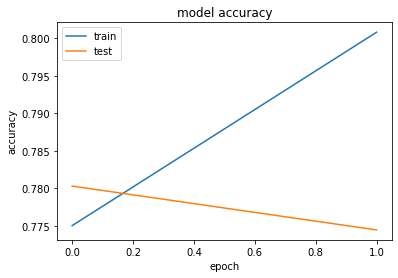

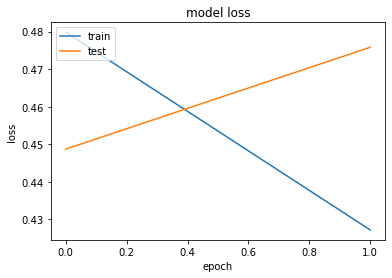

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
print("accuracy: ", history.history['accuracy'])
print("precision: ", history.history['precision'])
print("recall: ", history.history['recall'])
print("loss: ", history.history['loss'])

accuracy:  [0.7750309109687805, 0.8008114099502563]
precision:  [0.7488006353378296, 0.7790866494178772]
recall:  [0.8155574798583984, 0.829724133014679]
loss:  [0.4798397123813629, 0.427162230014801]


### Agricultural Label Counts

In [34]:
def count_label(data_gen, batch_count):
    agri_count = 0
    for i in range(batch_count):
        _, label = data_gen.__getitem__(i)
        batch_agri_count = np.sum(label)
        agri_count += batch_agri_count
        if i%1000 == 0:
              print('Accumulated counts of the agicultural label in batch ', i, ' is ', agri_count)

    return agri_count

In [35]:
print("Total batches to be counted is ", BATCH_COUNT)

Total batches to be counted is  18447


In [36]:
print("Total agricultural labels in the data set is ", count_label(data_gen, BATCH_COUNT))
print("The total image patches ", len(os.listdir(data_dir)))

Accumulated counts of the agicultural label in batch  0  is  16
Accumulated counts of the agicultural label in batch  1000  is  15694
Accumulated counts of the agicultural label in batch  2000  is  31414
Accumulated counts of the agicultural label in batch  4000  is  62929
Accumulated counts of the agicultural label in batch  5000  is  78623
Accumulated counts of the agicultural label in batch  6000  is  94358
Accumulated counts of the agicultural label in batch  8000  is  125674
Accumulated counts of the agicultural label in batch  9000  is  141431
Accumulated counts of the agicultural label in batch  10000  is  157135
Accumulated counts of the agicultural label in batch  11000  is  172876
Accumulated counts of the agicultural label in batch  12000  is  188536
Accumulated counts of the agicultural label in batch  13000  is  204386
Accumulated counts of the agicultural label in batch  15000  is  235850
Accumulated counts of the agicultural label in batch  16000  is  251628
Accumulated 